# Bitcoin Price Prediction with Regression Models

This notebook implements Linear Regression, Ridge Regression, and Lasso Regression models to predict Bitcoin prices using the preprocessed data.

In [31]:

!pip3 install pandas numpy scikit-learn matplotlib seaborn
print("Packages installed successfully!")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Packages installed successfully!


In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

## Load Data

Loading the preprocessed train, validation, and test sets for both h1 and h7 predictions.

In [22]:
# Load h1 data
h1_train = pd.read_csv('data/processed/h1_train.csv')
h1_val = pd.read_csv('data/processed/h1_val.csv')
h1_test = pd.read_csv('data/processed/h1_test.csv')

# Load h7 data
h7_train = pd.read_csv('data/processed/h7_train.csv')
h7_val = pd.read_csv('data/processed/h7_val.csv')
h7_test = pd.read_csv('data/processed/h7_test.csv')

print(f"H1 - Train: {h1_train.shape}, Val: {h1_val.shape}, Test: {h1_test.shape}")
print(f"H7 - Train: {h7_train.shape}, Val: {h7_val.shape}, Test: {h7_test.shape}")

H1 - Train: (1877, 71), Val: (402, 71), Test: (403, 71)
H7 - Train: (1873, 71), Val: (401, 71), Test: (402, 71)


In [38]:
def prepare_data(train_df, val_df, test_df, target_col):
    """Prepare features and target variables from datasets"""
    
    # Define feature columns (exclude date and target)
    feature_cols = [col for col in train_df.columns if col not in ['date', target_col]]
    
    # Prepare training data
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    
    # Prepare validation data
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]
    
    # Prepare test data
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_cols

# Prepare h1 data (target: y_btc_close_t+1)
X_train_h1, y_train_h1, X_val_h1, y_val_h1, X_test_h1, y_test_h1, features_h1 = prepare_data(
    h1_train, h1_val, h1_test, 'y_btc_close_t+1'
)

# Prepare h7 data (target: y_btc_close_t+7)
X_train_h7, y_train_h7, X_val_h7, y_val_h7, X_test_h7, y_test_h7, features_h7 = prepare_data(
    h7_train, h7_val, h7_test, 'y_btc_close_t+7'
)

print(f"H1 Features: {len(features_h1)}")
print(f"H7 Features: {len(features_h7)}")
print(f"H1 Training samples: {X_train_h1.shape[0]}")
print(f"H7 Training samples: {X_train_h7.shape[0]}")
print(f"H1 target column: y_btc_close_t+1")
print(f"H7 target column: y_btc_close_t+7")
print("\nNote: Data is already z-score normalized using train-only statistics from split.py")

H1 Features: 69
H7 Features: 69
H1 Training samples: 1877
H7 Training samples: 1873
H1 target column: y_btc_close_t+1
H7 target column: y_btc_close_t+7

Note: Data is already z-score normalized using train-only statistics from split.py


## Data Already Scaled

The data is already z-score normalized using train-only statistics from the `split.py` script. The features were scaled using mean and standard deviation computed only on the training set, then applied to validation and test sets. This prevents data leakage.


In [39]:
# Since data is already properly scaled using train-only stats, we can use it directly
print("Data is already properly scaled - no additional scaling needed!")
print("Features have been z-score normalized using train-only statistics.")
print("This prevents data leakage between train/val/test sets.")

Data is already properly scaled - no additional scaling needed!
Features have been z-score normalized using train-only statistics.
This prevents data leakage between train/val/test sets.


In [40]:
# Scale features for h1
scaler_h1 = StandardScaler()
X_train_h1_scaled = scaler_h1.fit_transform(X_train_h1)
X_val_h1_scaled = scaler_h1.transform(X_val_h1)
X_test_h1_scaled = scaler_h1.transform(X_test_h1)

# Scale features for h7
scaler_h7 = StandardScaler()
X_train_h7_scaled = scaler_h7.fit_transform(X_train_h7)
X_val_h7_scaled = scaler_h7.transform(X_val_h7)
X_test_h7_scaled = scaler_h7.transform(X_test_h7)

print("Feature scaling completed for both h1 and h7 datasets")

Feature scaling completed for both h1 and h7 datasets


In [41]:
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Evaluate model performance with multiple metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} - {dataset_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.6f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def train_and_evaluate_models(X_train, y_train, X_val, y_val, X_test, y_test, horizon_name):
    """Train and evaluate all three regression models"""
    results = {}
    models = {}
    
    print(f"\n{'='*50}")
    print(f"Training Models for {horizon_name}")
    print(f"{'='*50}")
    
    # Linear Regression
    print("\nTraining Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    models['Linear'] = lr
    
    # Predictions
    lr_val_pred = lr.predict(X_val)
    lr_test_pred = lr.predict(X_test)
    
    # Evaluation
    results['Linear'] = {
        'val': evaluate_model(y_val, lr_val_pred, 'Linear Regression', 'Validation'),
        'test': evaluate_model(y_test, lr_test_pred, 'Linear Regression', 'Test')
    }
    
    # Ridge Regression
    print("\nTraining Ridge Regression...")
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train, y_train)
    models['Ridge'] = ridge
    
    # Predictions
    ridge_val_pred = ridge.predict(X_val)
    ridge_test_pred = ridge.predict(X_test)
    
    # Evaluation
    results['Ridge'] = {
        'val': evaluate_model(y_val, ridge_val_pred, 'Ridge Regression', 'Validation'),
        'test': evaluate_model(y_test, ridge_test_pred, 'Ridge Regression', 'Test')
    }
    
    # Lasso Regression
    print("\nTraining Lasso Regression...")
    lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
    lasso.fit(X_train, y_train)
    models['Lasso'] = lasso
    
    # Predictions
    lasso_val_pred = lasso.predict(X_val)
    lasso_test_pred = lasso.predict(X_test)
    
    # Evaluation
    results['Lasso'] = {
        'val': evaluate_model(y_val, lasso_val_pred, 'Lasso Regression', 'Validation'),
        'test': evaluate_model(y_test, lasso_test_pred, 'Lasso Regression', 'Test')
    }
    
    return models, results

In [42]:
models_h1, results_h1 = train_and_evaluate_models(
    X_train_h1, y_train_h1, 
    X_val_h1, y_val_h1, 
    X_test_h1, y_test_h1, 
    "H1 (1-hour prediction)"
)


Training Models for H1 (1-hour prediction)

Training Linear Regression...

Linear Regression - Validation:
  MSE: 386.460641
  RMSE: 19.658602
  MAE: 12.094807
  R²: 0.983038

Linear Regression - Test:
  MSE: 235784.524346
  RMSE: 485.576487
  MAE: 245.162722
  R²: 0.988930

Training Ridge Regression...

Ridge Regression - Validation:
  MSE: 560.397341
  RMSE: 23.672713
  MAE: 15.585227
  R²: 0.975404

Ridge Regression - Test:
  MSE: 301181.604841
  RMSE: 548.800150
  MAE: 281.239009
  R²: 0.985860

Training Lasso Regression...

Lasso Regression - Validation:
  MSE: 375.775904
  RMSE: 19.384940
  MAE: 11.561632
  R²: 0.983507

Lasso Regression - Test:
  MSE: 214931.363047
  RMSE: 463.606906
  MAE: 235.702833
  R²: 0.989909


In [43]:
models_h7, results_h7 = train_and_evaluate_models(
    X_train_h7, y_train_h7, 
    X_val_h7, y_val_h7, 
    X_test_h7, y_test_h7, 
    "H7 (7-day Prediction)"
)


Training Models for H7 (7-day Prediction)

Training Linear Regression...

Linear Regression - Validation:
  MSE: 3065.284967
  RMSE: 55.365016
  MAE: 35.400979
  R²: 0.865957

Linear Regression - Test:
  MSE: 2184313.997933
  RMSE: 1477.942488
  MAE: 799.256720
  R²: 0.897488

Training Ridge Regression...

Ridge Regression - Validation:
  MSE: 3161.001753
  RMSE: 56.222787
  MAE: 35.163971
  R²: 0.861772

Ridge Regression - Test:
  MSE: 2158626.102192
  RMSE: 1469.226362
  MAE: 783.045097
  R²: 0.898694

Training Lasso Regression...

Lasso Regression - Validation:
  MSE: 3031.758813
  RMSE: 55.061409
  MAE: 35.240464
  R²: 0.867423

Lasso Regression - Test:
  MSE: 2158126.899578
  RMSE: 1469.056466
  MAE: 794.051014
  R²: 0.898717


/Users/tahawasiq/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e+05, tolerance: 9.959e+03
  model = cd_fast.enet_coordinate_descent(


In [44]:
def create_results_dataframe(results_h1, results_h7):
    """Create a comprehensive results dataframe"""
    data = []
    
    for horizon, results in [('H1', results_h1), ('H7', results_h7)]:
        for model_name in ['Linear', 'Ridge', 'Lasso']:
            for dataset in ['val', 'test']:
                metrics = results[model_name][dataset]
                data.append({
                    'Horizon': horizon,
                    'Model': model_name,
                    'Dataset': dataset.capitalize(),
                    'MSE': metrics['MSE'],
                    'RMSE': metrics['RMSE'],
                    'MAE': metrics['MAE'],
                    'R²': metrics['R2']
                })
    
    return pd.DataFrame(data)

results_df = create_results_dataframe(results_h1, results_h7)
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False, float_format='%.6f'))


COMPREHENSIVE RESULTS SUMMARY
Horizon  Model Dataset            MSE        RMSE        MAE       R²
     H1 Linear     Val     386.460641   19.658602  12.094807 0.983038
     H1 Linear    Test  235784.524346  485.576487 245.162722 0.988930
     H1  Ridge     Val     560.397341   23.672713  15.585227 0.975404
     H1  Ridge    Test  301181.604841  548.800150 281.239009 0.985860
     H1  Lasso     Val     375.775904   19.384940  11.561632 0.983507
     H1  Lasso    Test  214931.363047  463.606906 235.702833 0.989909
     H7 Linear     Val    3065.284967   55.365016  35.400979 0.865957
     H7 Linear    Test 2184313.997933 1477.942488 799.256720 0.897488
     H7  Ridge     Val    3161.001753   56.222787  35.163971 0.861772
     H7  Ridge    Test 2158626.102192 1469.226362 783.045097 0.898694
     H7  Lasso     Val    3031.758813   55.061409  35.240464 0.867423
     H7  Lasso    Test 2158126.899578 1469.056466 794.051014 0.898717


## Model Performance Visualization

In [45]:
def create_results_dataframe(results_h1, results_h7):
    """Create a comprehensive results dataframe"""
    data = []
    
    for prediction, results in [('H1', results_h1), ('H7', results_h7)]:
        for model_name in ['Linear', 'Ridge', 'Lasso']:
            for dataset in ['val', 'test']:
                metrics = results[model_name][dataset]
                data.append({
                    'Prediction': prediction,
                    'Model': model_name,
                    'Dataset': dataset.capitalize(),
                    'MSE': metrics['MSE'],
                    'RMSE': metrics['RMSE'],
                    'MAE': metrics['MAE'],
                    'R²': metrics['R2']
                })
    
    return pd.DataFrame(data)

results_df = create_results_dataframe(results_h1, results_h7)
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False, float_format='%.6f'))


COMPREHENSIVE RESULTS SUMMARY
Prediction  Model Dataset            MSE        RMSE        MAE       R²
        H1 Linear     Val     386.460641   19.658602  12.094807 0.983038
        H1 Linear    Test  235784.524346  485.576487 245.162722 0.988930
        H1  Ridge     Val     560.397341   23.672713  15.585227 0.975404
        H1  Ridge    Test  301181.604841  548.800150 281.239009 0.985860
        H1  Lasso     Val     375.775904   19.384940  11.561632 0.983507
        H1  Lasso    Test  214931.363047  463.606906 235.702833 0.989909
        H7 Linear     Val    3065.284967   55.365016  35.400979 0.865957
        H7 Linear    Test 2184313.997933 1477.942488 799.256720 0.897488
        H7  Ridge     Val    3161.001753   56.222787  35.163971 0.861772
        H7  Ridge    Test 2158626.102192 1469.226362 783.045097 0.898694
        H7  Lasso     Val    3031.758813   55.061409  35.240464 0.867423
        H7  Lasso    Test 2158126.899578 1469.056466 794.051014 0.898717


## Feature Importance Analysis (Lasso Coefficients)

Feature Importance Analysis


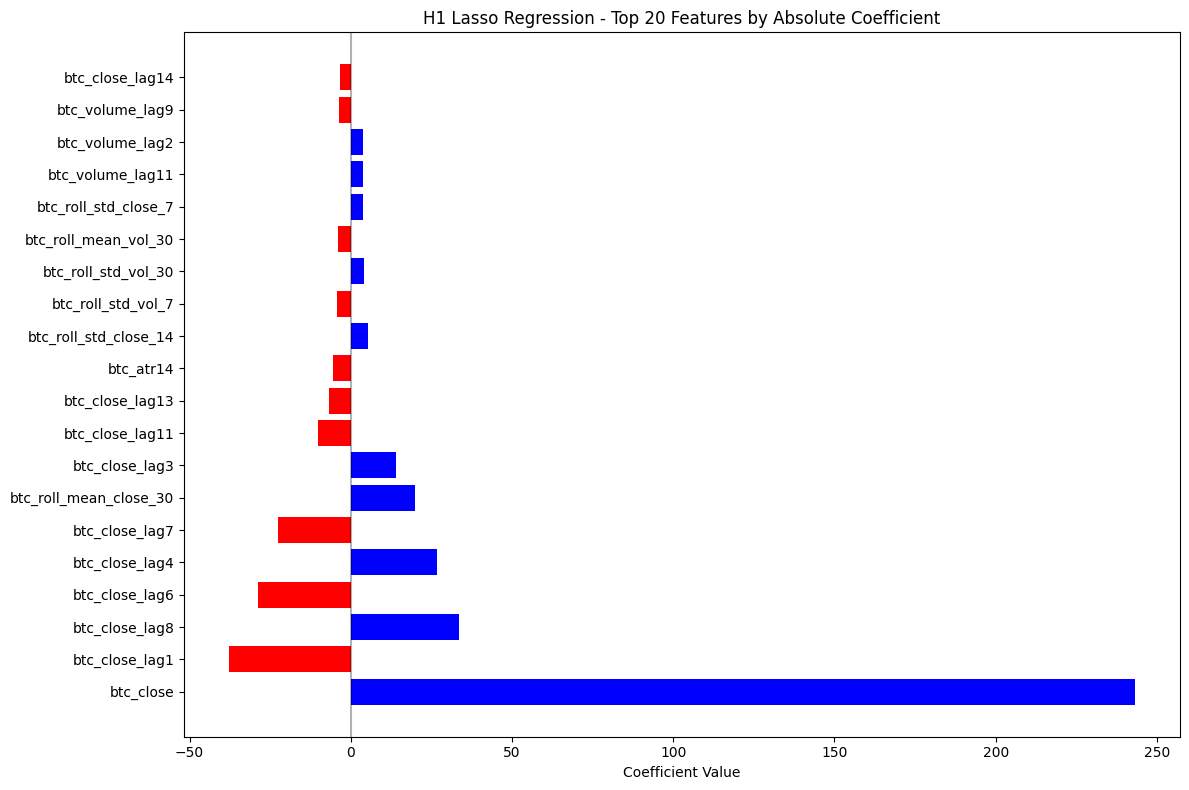

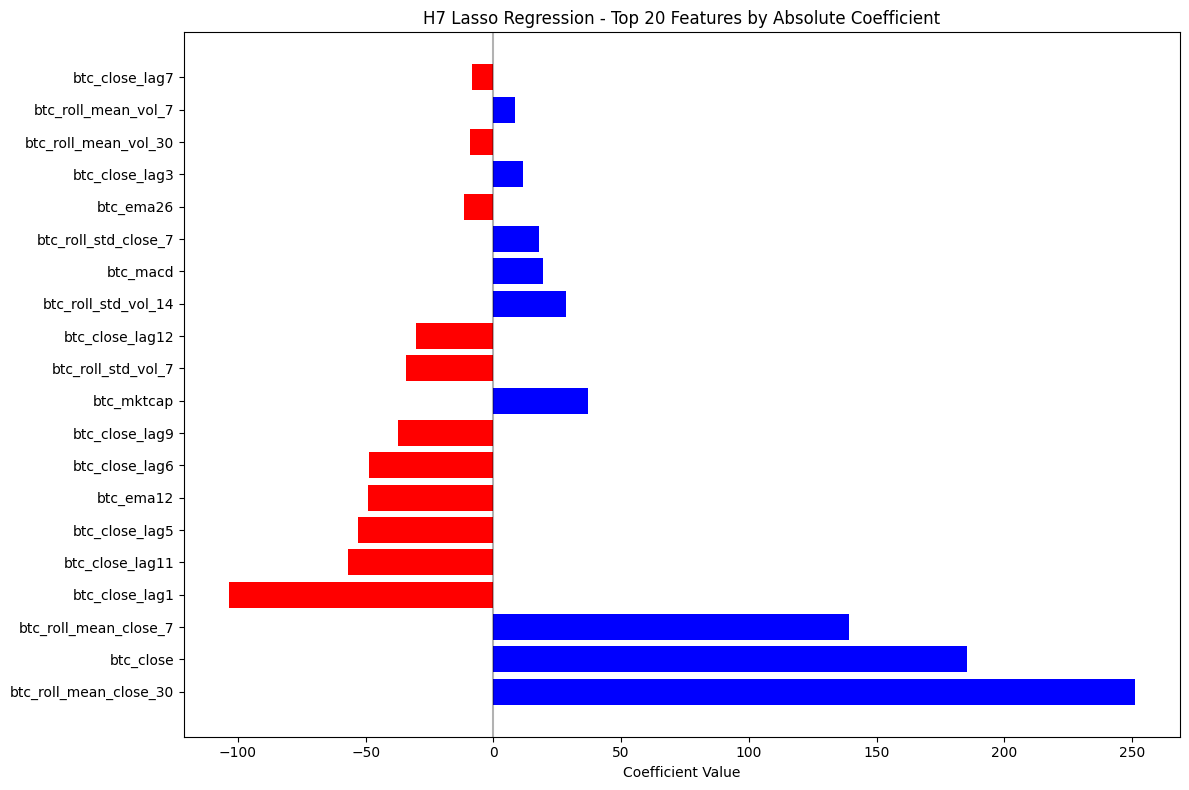

In [46]:
def plot_feature_importance(model, feature_names, title, top_n=20):
    """Plot feature importance based on model coefficients"""
    if hasattr(model, 'coef_'):
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': model.coef_
        })
        
        # Get top features by absolute coefficient value
        coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
        top_features = coef_df.nlargest(top_n, 'abs_coef')
        
        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'{title} - Top {top_n} Features by Absolute Coefficient')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return top_features
    else:
        print(f"Model {title} does not have coefficients")
        return None

# Feature importance for Lasso models
print("Feature Importance Analysis")
print("="*50)

# H1 Lasso
h1_lasso_features = plot_feature_importance(models_h1['Lasso'], features_h1, 'H1 Lasso Regression')

# H7 Lasso  
h7_lasso_features = plot_feature_importance(models_h7['Lasso'], features_h7, 'H7 Lasso Regression')

## Model Summary and Conclusions

In [47]:
print("\n" + "="*80)
print("MODEL SUMMARY AND CONCLUSIONS")
print("="*80)

# Find best models
test_results = results_df[results_df['Dataset'] == 'Test']

print("\nBest models by R² score:")
for prediction in ['H1', 'H7']:
    prediction_data = test_results[test_results['Prediction'] == prediction]
    best_model = prediction_data.loc[prediction_data['R²'].idxmax()]
    print(f"  {prediction}: {best_model['Model']} (R² = {best_model['R²']:.6f})")

print("\nBest models by RMSE score:")
for prediction in ['H1', 'H7']:
    prediction_data = test_results[test_results['Prediction'] == prediction]
    best_model = prediction_data.loc[prediction_data['RMSE'].idxmin()]
    print(f"  {prediction}: {best_model['Model']} (RMSE = {best_model['RMSE']:.6f})")

# Feature selection info for Lasso
print("\nLasso Regression Feature Selection:")
h1_lasso_nonzero = np.sum(np.abs(models_h1['Lasso'].coef_) > 1e-6)
h7_lasso_nonzero = np.sum(np.abs(models_h7['Lasso'].coef_) > 1e-6)
print(f"  H1: {h1_lasso_nonzero}/{len(features_h1)} features selected")
print(f"  H7: {h7_lasso_nonzero}/{len(features_h7)} features selected")

print("\nKey Observations:")
print("  1. Compare model performance across different prediction timeframes")
print("  2. Regularization effects of Ridge vs Lasso regression")
print("  3. Feature selection capabilities of Lasso regression")
print("  4. Model stability across validation and test sets")


MODEL SUMMARY AND CONCLUSIONS

Best models by R² score:
  H1: Lasso (R² = 0.989909)
  H7: Lasso (R² = 0.898717)

Best models by RMSE score:
  H1: Lasso (RMSE = 463.606906)
  H7: Lasso (RMSE = 1469.056466)

Lasso Regression Feature Selection:
  H1: 53/69 features selected
  H7: 62/69 features selected

Key Observations:
  1. Compare model performance across different prediction timeframes
  2. Regularization effects of Ridge vs Lasso regression
  3. Feature selection capabilities of Lasso regression
  4. Model stability across validation and test sets
